The "Emotions" dataset is a collection of English Twitter messages meticulously annotated with six primary emotions: anger, fear, joy, love, sadness, and surprise. The goal of using this data is to gain insights into the emotional spectrum expressed in short-form text on social media, offering valuable resources for understanding and analyzing patterns of emotional expression in online communication

In [59]:
# Installing necessary dependencies

%pip install pandas seaborn matplotlib plotly wordcloud -U kaleido scikit-learn==1.2.2 imblearn xgboost


In [1]:
# Necessary imports

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk

from plotly import graph_objs as go
from wordcloud import WordCloud
from collections import Counter
from typing import List, Tuple
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

pd.options.mode.chained_assignment = None


**PART 1 - EDA**

In [60]:
emotions_df = pd.read_csv("emotions_df.csv")
emotions_df.head()

In [3]:
# Dropping irrelevant column

emotions_df = emotions_df.drop(["Unnamed: 0"], axis=1)
emotions_df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
19995,i just keep feeling like someone is being unki...,3
19996,im feeling a little cranky negative after this...,3
19997,i feel that i am useful to my people and that ...,1
19998,im feeling more comfortable with derby i feel ...,1


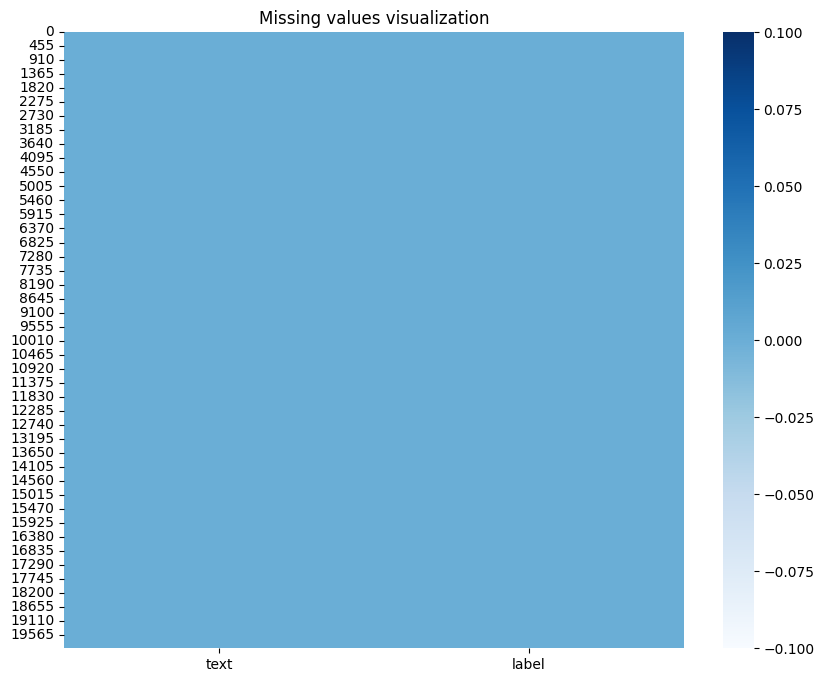

In [4]:
# Checking the presence of missing values

plt.figure(figsize=(10, 8))
sns.heatmap(emotions_df.isna(), cmap="Blues")
plt.title("Missing values visualization")
plt.show()

There are no missing values in this dataset

In [5]:
# Checking for duplicates, as duplicates can lead to inaccurate analysis, biased models, and inefficient resource use

emotions_df.duplicated().sum()

1

In [6]:
# Dropping duplicates

emotions_df = emotions_df.drop_duplicates()

**Visualizing the distribution of the target class**

For better readability, I will convert the encoded labels into their correspoding emotions - the emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)

In [7]:
label_to_emotion = {
    0 : "sadness",
    1 : "joy",
    2 : "love",
    3 : "anger",
    4 : "fear",
    5 : "surprise"
}

In [8]:
emotions_df["label_decoded"] = emotions_df["label"].apply(lambda x: label_to_emotion.get(x))

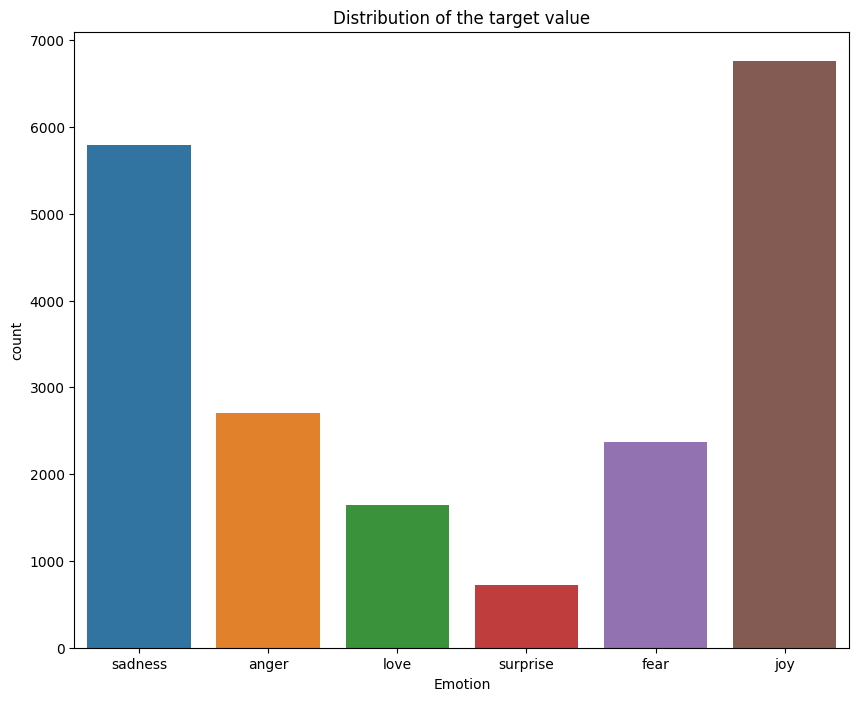

In [9]:
plt.figure(figsize=(10, 8))

sns.countplot(x=emotions_df["label_decoded"], hue=emotions_df["label_decoded"])
plt.title("Distribution of the target value")
plt.xlabel("Emotion")
plt.show()

It is clearly visible, that in this dataset we deal with class imbalance. Recognizing and addressing class imbalance is crucial for developing robust and fair machine learning models that accurately capture the underlying patterns in the data, as machine learning models trained on imbalanced data might become biased.

In [10]:
# This dataset is created for the visualization purposes - it includes the name of each emotion and the corresponding frequency of occurrences of that emotion within the dataset

emotions_count_df = emotions_df.groupby("label_decoded")["text"].count().reset_index().sort_values(by="text", ascending=False)

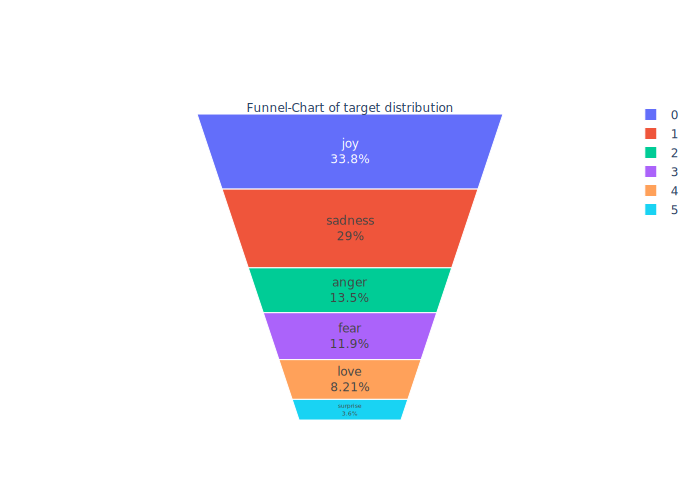

In [11]:
fig = go.Figure(go.Funnelarea(
    text = emotions_count_df.label_decoded,
    values = emotions_count_df.text,
    title = {"position": "top center", "text": "Funnel-Chart of target distribution"}
    ))
fig.show("svg")

In this dataset, joy is the most popular emotion, which is expected since people generally prefer to share positive news on social media platforms. Conversely, surprise ranks as the least popular emotion.

**Visualizing and analyzing the word frequencies**

Now, let's delve more into the text data itself. A word cloud is a data visualization technique that might be useful here, as it displays the most frequently occurring words in a text corpus. The purpose of a word cloud is to provide a visual representation of the prominent words within the text data, where the size of each word corresponds to its frequency of occurrence

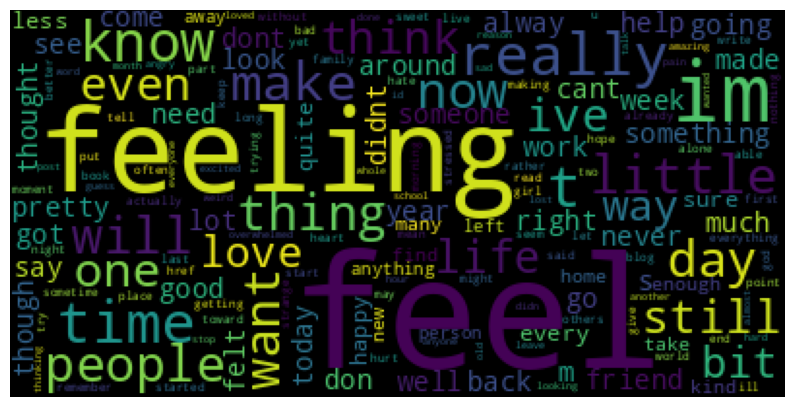

In [12]:
# Convert the text data to strings and concatenate them
text_data = ' '.join(emotions_df["text"].astype(str))

# Generate the WordCloud
wc = WordCloud(collocations=False).generate(text_data)

plt.figure(figsize=(10, 8))
plt.imshow(wc)
plt.axis("off")
plt.show()

It's evident that "feel" and "feeling" are the most common words in the text. These words are highly prominent, especially in discussions related to emotions

**Word clouds are visually striking but lack depth in conveying meaningful information beyond a few highlighted words. On the other hand, while bar plots may not be as visually appealing, they offer a more informative representation of data, making it easier to analyze and interpret. Now, let's take a look at some bar plots to dive deeper into the textual data**

In [13]:
def create_corpus(text: str) -> List[str]:
    text_list = text.split()
    return text_list

In [14]:
emotions_df['text_list'] = emotions_df['text'].apply(create_corpus)

In [15]:
corpus = []
for text_list in emotions_df['text_list']:
    corpus.extend(text_list)

In [16]:
most_common_words = Counter(corpus).most_common(15)
most_common_words

[('i', 32241),
 ('feel', 13937),
 ('and', 11996),
 ('to', 11207),
 ('the', 10462),
 ('a', 7748),
 ('feeling', 6431),
 ('that', 6314),
 ('of', 6182),
 ('my', 5326),
 ('in', 4239),
 ('it', 3922),
 ('like', 3616),
 ('so', 3127),
 ('im', 3055)]

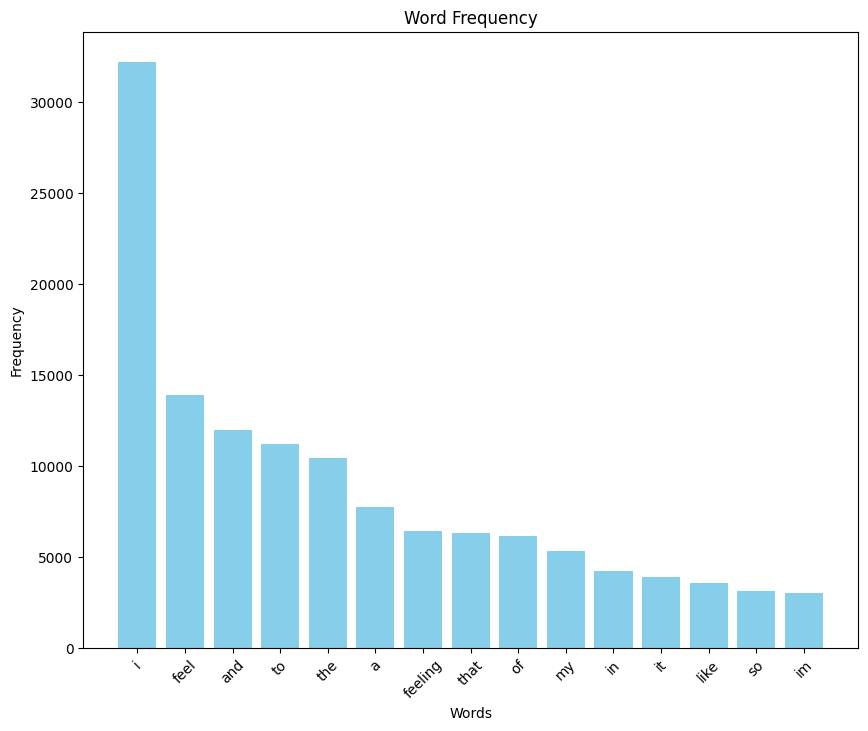

In [17]:
# Unzip the list of tuples into two lists
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45)
plt.show()

This plot provides valuable insights into our data. Notably, words like "feel" and "feeling" hold significant prominence, consistent with our observations from the word cloud. However, beyond these, the plot mainly showcases common stopwords that don't contribute much to our analysis. The word "I" emerges as the most frequently used term, which is expected given its common usage in personal expressions. We'll address stopwords during the preprocessing step to refine our dataset for more meaningful analysis.

We could also analyze the word frequency for each emotion separately, but this can also be done after processing, as it will be more informative.

**Exploring the relationship between text length and emotion**

As part of our exploratory data analysis (EDA), we can investigate whether there's a relationship between the length of messages and the expressed emotion.

In [18]:
def message_length(words: List[str]) -> int:
  length = len(words)
  return length

In [19]:
emotions_df['text_length'] = emotions_df['text_list'].apply(message_length)

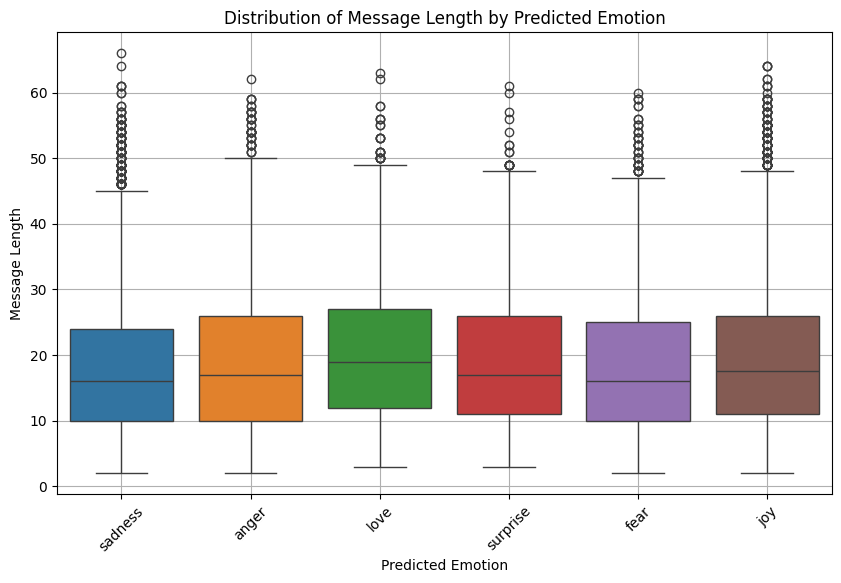

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label_decoded', y='text_length', hue='label_decoded', data=emotions_df)
plt.xlabel('Predicted Emotion')
plt.ylabel('Message Length')
plt.title('Distribution of Message Length by Predicted Emotion')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Looking at this boxplot, we can see that for each predicted emotion, the median text length is similar. It implies that the central tendency of text length remains consistent across different emotions. This observation suggests that text length might not be associated with the predicted emotion.
Among all the text messages analyzed, the longest outlier, i.e., the text with the greatest length compared to others, is associated with someone experiencing sadness


**PART 2 - DATA PREPROCESSING**

Text preprocessing is essential for transforming raw text data into a format that is suitable for analysis and machine learning models.

We need to start of with cleaning our data - this step is really important, as it helps to extract only the relevant information from the corpus. Raw text data may include punctuation, numbers, links etc. that are not informative and can lead to lower model accuracy.

In [21]:
def clean_data(text: str) -> str:

  # Converting all characters to lowercase
  text = text.lower()

  # Removing links
  text = re.sub('https?://\S+|www\.\S+', '', text)

  # Removing HTML tags
  text = re.sub('<[^<]+?>', '', text)

  # Removing usernames
  text = re.sub('@[^\s]+', ' ', text)

  # Removing words that contain digits (ex. h3llo)
  text = re.sub('\w*\d\w*', '', text)

  # Removing single characters
  text = re.sub(r'\b\w\b', '', text)

  # Removing everything except letters from the text - it includes removing punctuation, digits, special characters
  text = re.sub(r'[^a-z\s]', ' ', text).strip()

  # Removing whitespace
  text = " ".join(text.split())

  # Removing newline characters
  text = re.sub('\n', '', text)


  return text


After cleaning our data, we can focus on removing stopwords and lemmatization. Stop word removal is a crucial text preprocessing step in sentiment analysis that involves removing common and irrelevant words that are unlikely to convey much sentiment. Lemmatization is a technique used to reduce words to their root forms. It involves reducing words to their base form based on their part of speech. By reducing words to their base form, lemmatization reduces the dimensionality of the feature space, which can lead to better model performance.

In [61]:
nltk.download('all', quiet=True)

In [23]:
def remove_stopwords_and_lemmatize(text: str) -> str:

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]


    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [25]:
emotions_df["text"] = emotions_df["text"].apply(clean_data)
emotions_df["text"] = emotions_df["text"].apply(remove_stopwords_and_lemmatize)

After completing those steps, our text data is in a format that is way more suitable for analysis. Before moving further, we can visualize preproccesed data as it yields more informative insights compared to visualizing raw text data. The initial visualizations were mostly used to get a grip of what the dataset holds - now the created plots will help us understand better what the data reveals.

Let's redo the word frequency plot to illustrate how cleaning data affects the distribution of word frequencies.

In [26]:
emotions_df['text_list_cleaned'] = emotions_df['text'].apply(create_corpus)


In [27]:
corpus = []
for text_list in emotions_df['text_list_cleaned']:
    corpus.extend(text_list)

In [62]:
most_common_words = Counter(corpus).most_common(15)

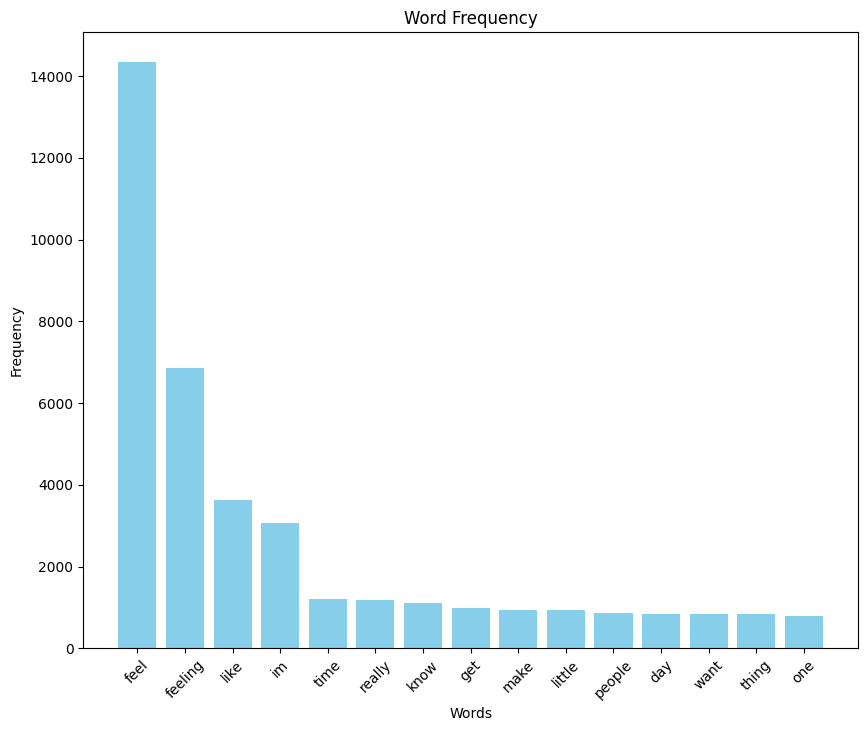

In [29]:
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45)
plt.show()

By comparing those two plots, a striking contrast becomes apparent. This is mostly due to stop words removal. This newly created plot reveals a more refined representation of the text's content. Words with semantic significance,now emerge as the most frequent, providing deeper insights into the underlying themes and topics present in the text.
"Feel" and "feeling" appear as two leading words, which is not surprising since we are analyzing emotion-related entries.

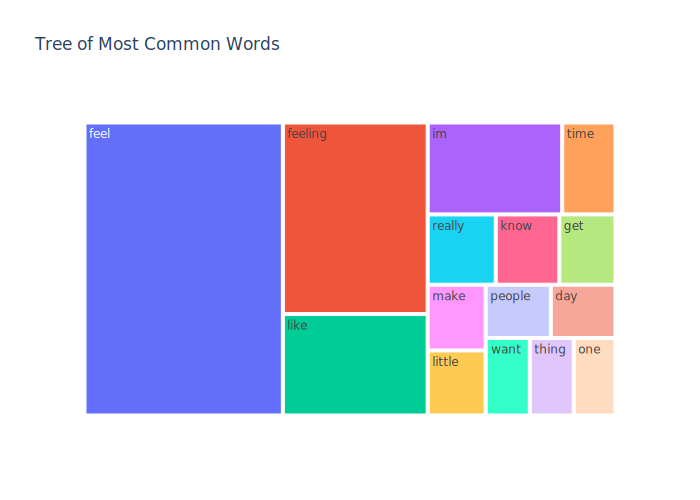

In [30]:
data = {"words": words, "values": frequencies}

fig = px.treemap(data, path=["words"], values="values",title='Tree of Most Common Words')
fig.show("svg")

What might be interesting is delving into the exploration of emotions by visualizing the most common words associated with distinct emotional states that are present in the dataset

In [31]:
# This utility function brings the preceding code together and serves as a versatile tool for analyzing and visualizing emotional content within textual data

def common_words_by_emotion(emotion: str) -> None:
  corpus = []
  for text_list in emotions_df.loc[emotions_df['label_decoded'] == emotion, 'text_list_cleaned']:
      corpus.extend(text_list)
  most_common_words = Counter(corpus).most_common(15)
  words, frequencies = zip(*most_common_words)
  data = {"words": words, "values": frequencies}

  fig = px.treemap(data, path=["words"], values="values",title=f'Tree of Most Common Words for {emotion}')
  fig.show("svg")

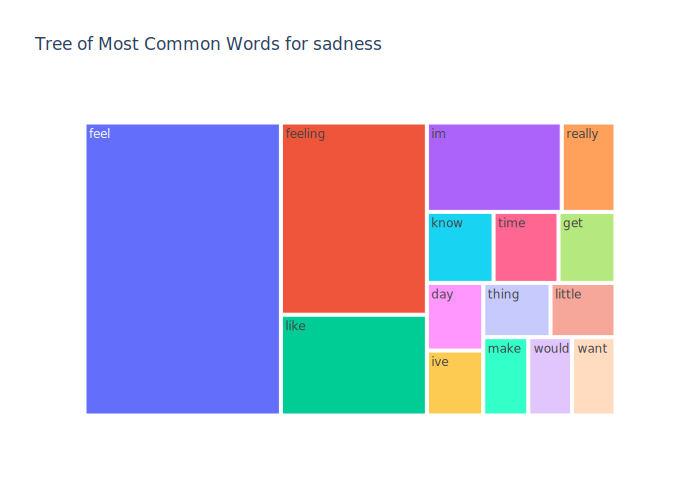

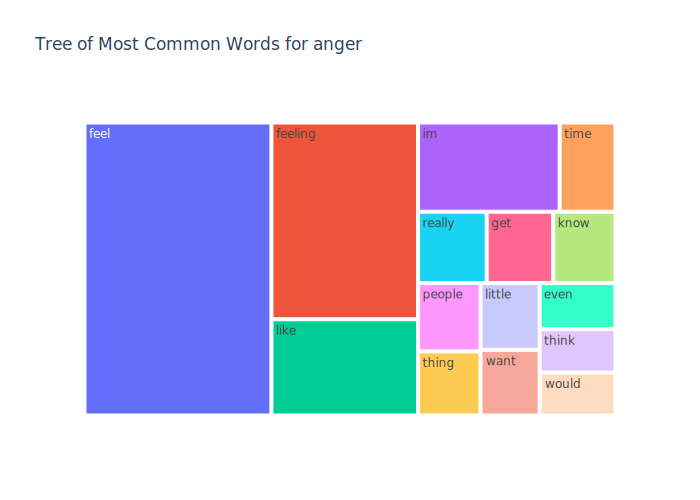

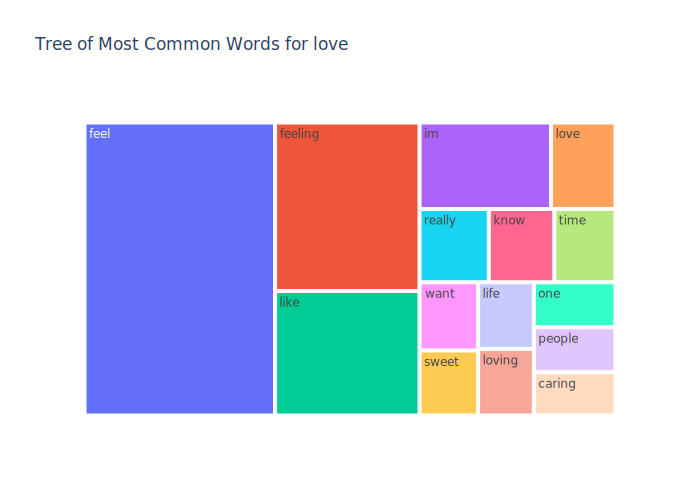

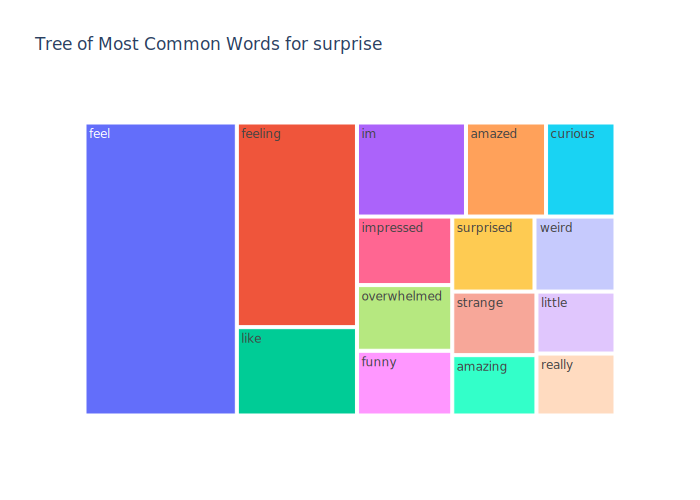

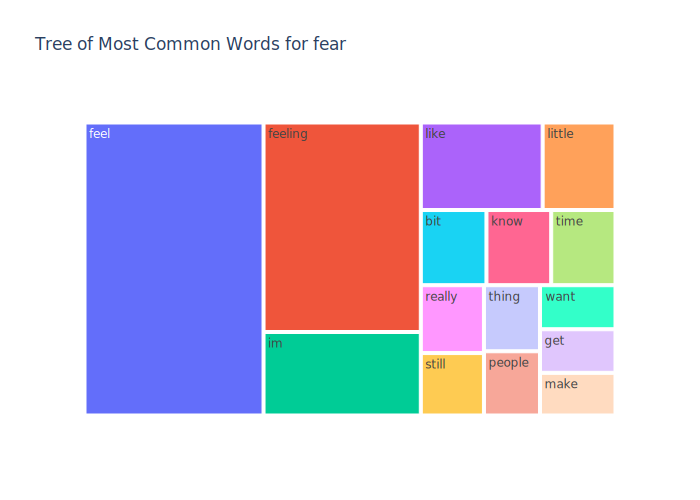

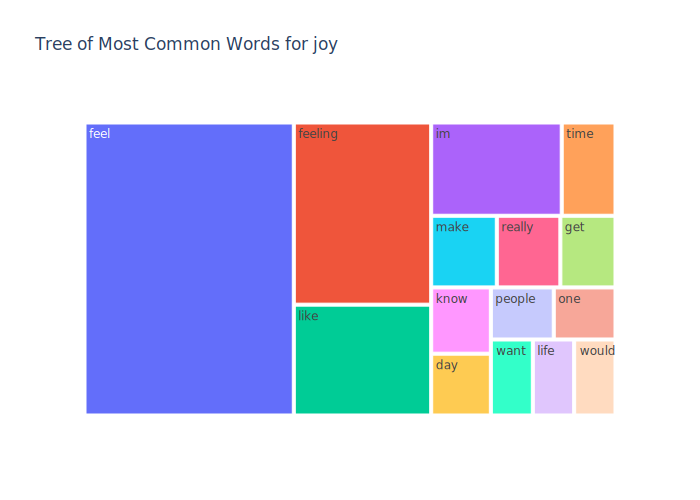

In [32]:
for emotion in emotions_df["label_decoded"].unique():
  common_words_by_emotion(emotion)

Comparing those plots, there is a noticable resemblance in most popular words among all emotions. "Feel" and "feeling" take the lead, which is not surprising. The next two most common words - "like" and "im" are also shared, but apart from that, there is a visible difference. "Im" is frequently used to express personal feelings or experiences in first-person narratives, and "like" is a word often used for comparisons and similes to vividly express feelings or experiences.
When it comes to other prominent words, words associated with text classified as "surprise" seem to stand out, as there are a lot of adjectives present that express emotions.

The infrequent occurrence of surprise in the dataset, as it is the least represented class, may be attributed to the intensity of the language used to describe it compared to other emotions. The distinctiveness of the most common words associated with surprise compared to those of other emotions suggests a unique linguistic pattern for surprise within the dataset

Another emotion that displays some variation is "love," characterized by the presence of love-related words, though not to the same extent.

When it comes to other emotions, the most prevalent words are less specific and may not distinctly reflect emotional states.

What can be interesting in this analysis, is seeing how similiar those emotions are to each other in the terms of words. To see that, we can take leverage of **CountVectorizer - a technique used to convert text data into numerical vectors. It operates by tokenizing input text into individual words (or tokens) and counting the occurrences of each word in each document. This process results in a matrix representation where rows correspond to documents, and columns correspond to the unique words found in the entire corpus.** Additionally, to compute the similarity, cosine similarity will be counted as it provides a robust way to understand the semantic similarity between documents.

In [33]:
vectorizer = CountVectorizer()

# Aggregate text data for each emotion
aggregated_texts = emotions_df.groupby('label_decoded')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Convert text data into numerical vectors using CountVectorizer
X = vectorizer.fit_transform(aggregated_texts['text'])

# Calculate pairwise similarity between all pairs of emotions
pairwise_similarity = cosine_similarity(X)

# Create a DataFrame for better visualization
pairwise_similarity_df = pd.DataFrame(pairwise_similarity, columns=aggregated_texts['label_decoded'], index=aggregated_texts['label_decoded'])

# Iterate through each emotion and find the closest emotion
for emotion in aggregated_texts['label_decoded']:
    # Find the row corresponding to the current emotion
    similarity_row = pairwise_similarity_df.loc[emotion]
    # Exclude similarity with itself
    closest_emotion = similarity_row.drop(emotion).idxmax()
    # Get the maximum similarity value
    max_similarity = similarity_row[closest_emotion]
    # Print the result
    print(f"The emotion '{emotion}' is closest to '{closest_emotion}' with a similarity of {max_similarity:.3f}")

The emotion 'anger' is closest to 'sadness' with a similarity of 0.974
The emotion 'fear' is closest to 'sadness' with a similarity of 0.963
The emotion 'joy' is closest to 'sadness' with a similarity of 0.980
The emotion 'love' is closest to 'joy' with a similarity of 0.968
The emotion 'sadness' is closest to 'joy' with a similarity of 0.980
The emotion 'surprise' is closest to 'fear' with a similarity of 0.927


It's noteworthy that sadness has high similarity scores with anger, fear and joy. This suggests that sadness is closely related to a range of emotions, indicating its complex nature and potential for overlap with other emotional states. Apart from that, high frequency of "joy" and "sadness" occurrences within the dataset can influence the cosine similarity scores between them and other emotions. Given their higher prevalence, they might end up being more frequently paired with other emotions, potentially affecting the calculated similarity scores.

Another aspect worth exploring is creating an ngram visualization to identify frequently co-occurring words. This can provide valuable insights into which words are commonly used together. We will focus on bigrams and trigrams.

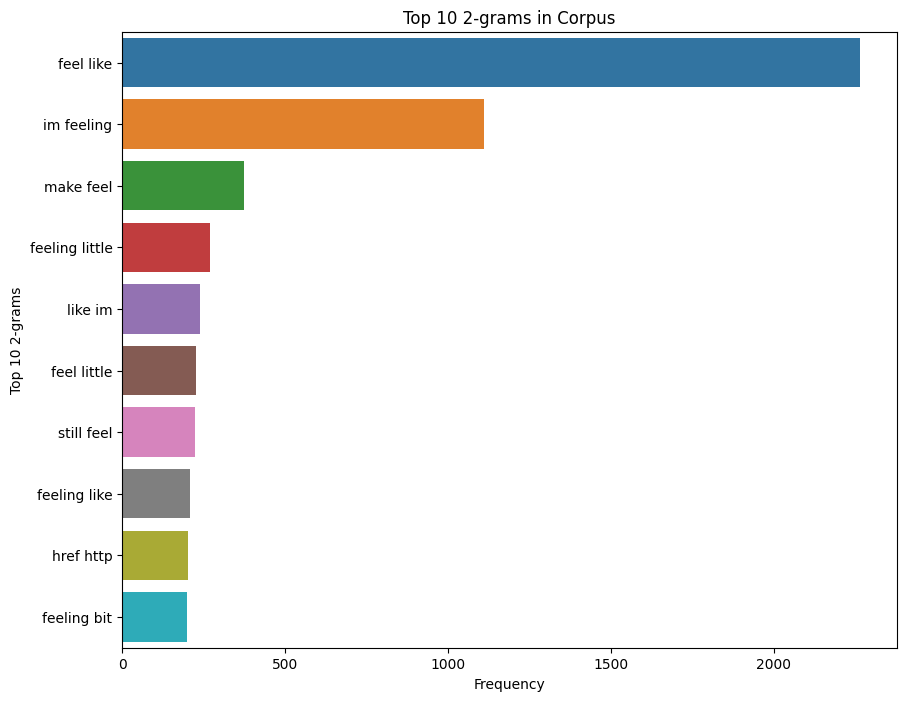

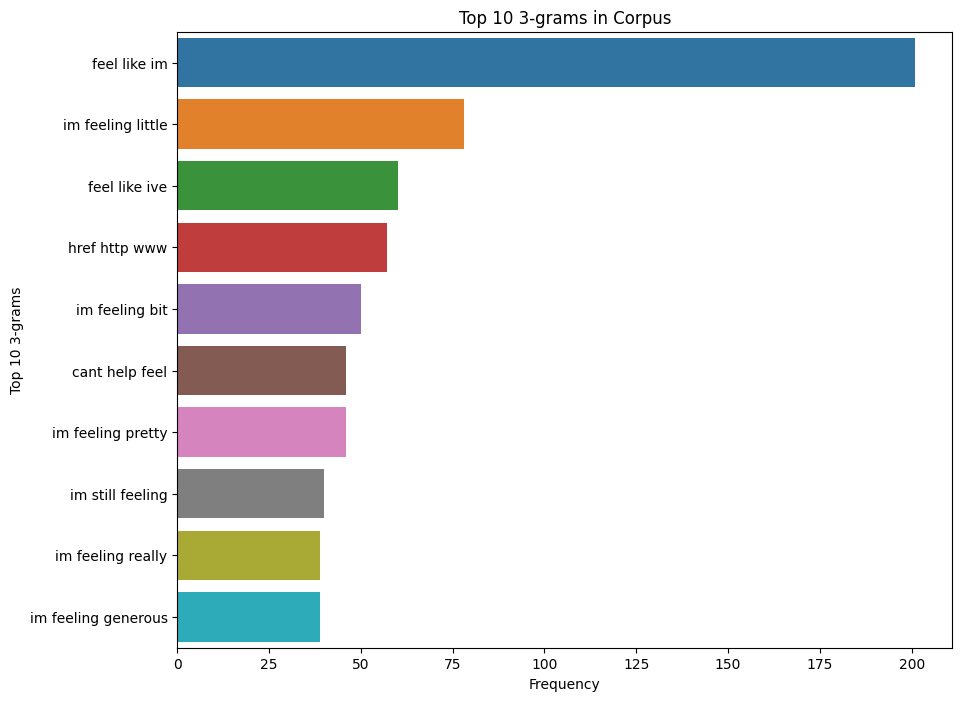

In [34]:
def plot_top_ngram(corpus: pd.Series, n: int, top_n: int = 10) -> None:
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of (word, frequency) tuples
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Select the top ngrams based on their frequency
    top_n_words = words_freq[:top_n]

    # Extract labels (ngram sequences) and frequencies for plotting
    ngram_labels, frequencies = map(list, zip(*top_n_words))
    plt.figure(figsize=(10, 8))
    sns.barplot(x=frequencies, y=ngram_labels, hue=ngram_labels)  # Plotting frequencies on x-axis and ngram labels on y-axis
    plt.xlabel('Frequency')
    plt.ylabel(f'Top {top_n} {n}-grams')
    plt.title(f'Top {top_n} {n}-grams in Corpus')
    plt.show()

plot_top_ngram(emotions_df["text"], 2, top_n=10)
plot_top_ngram(emotions_df["text"], 3, top_n=10)

The analysis of the top ngrams reveals common phrases such as 'feel like,' 'I'm feeling like,' and 'I'm like.' While these phrases appear frequently in the text data, they primarily reflect colloquial language patterns rather than conveying substantial information about the underlying themes or topics. As a result, these ngrams may not provide significant insights into the content of the corpus.
A notable observation in the most common ngrams is the presence of phrases like "href http" and "href http www". Despite attempts to clean the data, including removing unecessary parts using regular expressions, some instances of these link-related ngrams persisted. Therefore, manual removal of occurrences of "href http www" may be necessary to ensure data accuracy for further analysis.

In [35]:
emotions_df['text'] = emotions_df['text'].apply(lambda x: re.sub(r'href\s*http\s*www', '', x))

**After such thorough analysis, we can start preparing the data for ML model to use. Although the raw text data has undergone significant transformation, we still need to perform a few additional steps.**

**PART 3 - FURTHER PREPARATION**

Before performing any further steps, our dataset should be splitted into train and test sets to avoid data leakage. For this part we will leave only the relevant columns in the dataset - cleaned and lemmatized text and its predicted label.

In [36]:
emotions_df = emotions_df[["text", "label"]]

In [37]:
# The sample method is used to randomly select a fraction of rows from the original DataFrame
train_df = emotions_df.sample(frac=0.8,random_state=44)
test_df = emotions_df.drop(train_df.index)

It is well known that ML models understand only numeric data. This makes **vectorization** a crucial step in our data prepartation, as it transforms text data into numeric representation. There are various algorithms that handle such conversion. One of them is **TF-IDF - a technique that measures the importance of words in a document relative to a corpus. It considers both the frequency of a term within a document and its rarity across the corpus, providing a weighted representation that captures the significance of terms in the context of the document.**

In [38]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

As I mentioned before, our target class is imbalanced. An imbalanced target class in a machine learning dataset can pose challenges and introduce biases that affect the model's performance. We can try to balance the target class using SMOTE (Synthetic Minority Over-sampling Technique). It is a technique to up-sample the minority classes while avoiding overfitting. It does this by generating new synthetic examples close to the other points (belonging to the minority class) in feature space

In [39]:
oversample = SMOTE(random_state=15)
X_train, y_train = oversample.fit_resample(X_train_tfidf, train_df["label"])

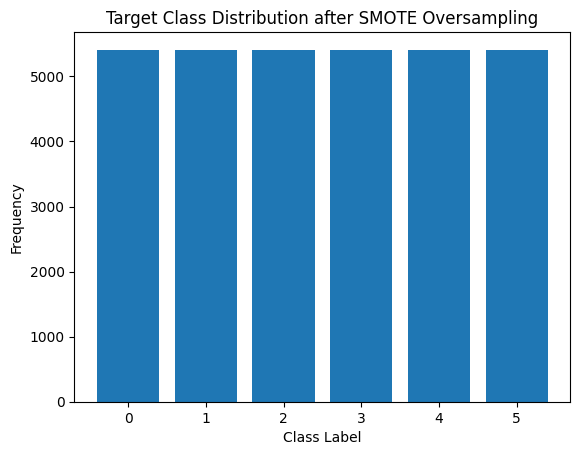

In [40]:
# Count the occurrences of each class label in the oversampled y_train
class_counts = y_train.value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Target Class Distribution after SMOTE Oversampling')
plt.show()

After applying SMOTE oversampling, the target class distribution is balanced, ensuring that each class has an equal representation in the training set. This is only applied to the training data to ensure the integrity of the testing process as it is supposed to evaluate the model's performance on unseen data without any prior adjustments.

**PART 4 - MODEL DEVELOPMENT**

Now it is finally time to move on to model development. We'll begin by selecting suitable algorithms and fine-tuning them to achieve the best performance for our emotions prediction task.

**1. Logistic Regression**

We will begin our exploration with one of the most established and widely used algorithms: logistic regression. Logistic regression serves as an excellent starting point due to its simplicity and effectiveness in modeling binary and multiclass classification problems.

In scikit-learn, the LogisticRegression class has an multi_class parameter, which allows you to specify the strategy for handling multiclass classification. It defaults to 'auto' which automatically selects the appropriate algorithm based on the nature of the problem.

In [41]:
y_true = test_df["label"]

In [42]:
log_reg = LogisticRegression(max_iter=1200)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test_tfidf)

In [43]:
# Labels for confusion matrix
class_names = [label_to_emotion[i] for i in range(len(label_to_emotion))]

In [44]:
def evaluate_performance(y_true: pd.Series, y_pred: np.array) -> None:

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  conf_matrix = confusion_matrix(y_true, y_pred)

  print("PERFORMANCE ON TEST DATASET: ")
  print("Accuracy", accuracy)
  print("Precision", precision)
  print("Recall", recall)
  print("F1-score", f1)

  # We can also take use of a confusion matrix. It is a useful tool that shows the performance of a classification model.
  # Along the diagonal are correctly classified instances, while off-diagonal elements represent misclassifications

  sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

PERFORMANCE ON TEST DATASET: 
Accuracy 0.885
Precision 0.8886637463901645
Recall 0.885
F1-score 0.8860168108322659


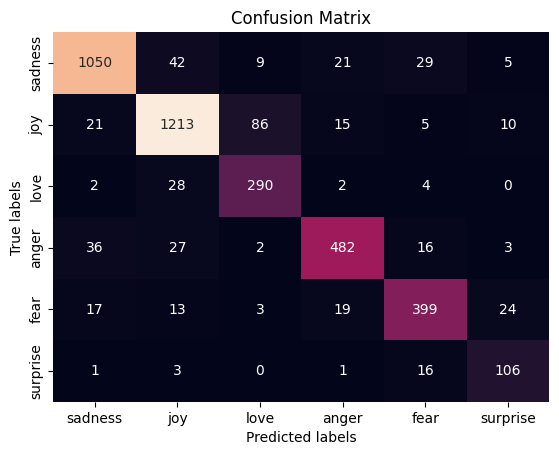

In [45]:
evaluate_performance(y_true, y_pred)

**Hyperparameter tuning**

When instantiating our model, we didn't specify any hyperparameters except max_iter. This raises the question: could some combinations of hyperparameters potentially lead to better model performance? This is where hyperparameter tuning comes into play — a process that systematically explores different combinations of hyperparameters to find the optimal configuration for a machine learning model

In [54]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'saga', 'lbfgs']
}


In [63]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_macro', verbose=3)
grid_search.fit(X_train, y_train)

In [56]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 10, 'solver': 'newton-cg'}


In [57]:
print(grid_search.best_score_)

0.9623887580139799


PERFORMANCE ON TEST DATASET: 
Accuracy 0.88825
Precision 0.889795427963012
Recall 0.88825
F1-score 0.8887749234671217


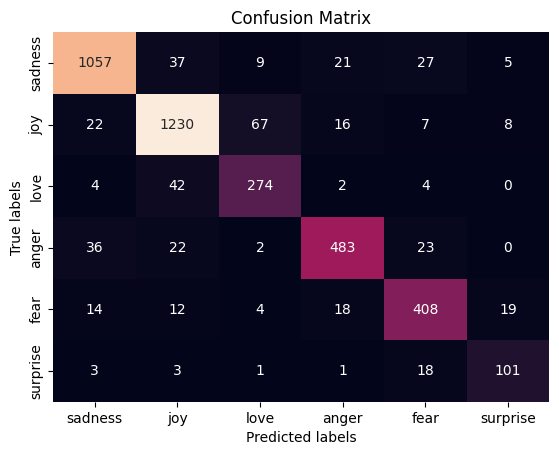

In [58]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_tfidf)
evaluate_performance(y_true, y_pred)

Hyperparameter tuning slightly improved the model's performance, but this improval is not satisfactory. When looking at the confusion matrix it is noticable that for most emotions, the number of correctly classified instances increased - except for love and surprise, which is concerning since those two emotions are the least numerous. This suggests the need for exploring alternative model architectures.

**2. XGBoost**

At its core, XGBoost is an ensemble learning technique based on the gradient boosting. It builds a series of decision trees sequentially, where each subsequent tree corrects the errors made by the previous ones. The "gradient" in XGBoost refers to the gradient descent optimization algorithm used to minimize the loss function when constructing each tree.

In [64]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

In [47]:
y_pred = xgb_model.predict(X_test_tfidf)

PERFORMANCE ON TEST DATASET: 
Accuracy 0.88475
Precision 0.8919195121157126
Recall 0.88475
F1-score 0.8865376366864536


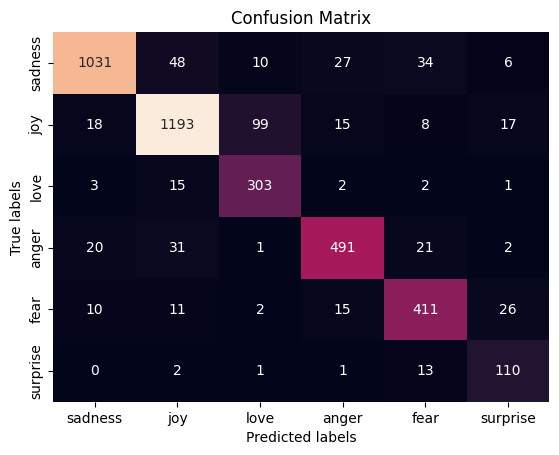

In [48]:
evaluate_performance(y_true, y_pred)

There's a noticeable improvement in classifying the less common classes, yet there's a decline observed in accurately categorizing the two most prevalent emotions - joy and sadness. Let's see if we can enhance this performance with hyperparameter tuning.



**Hyperparameter tuning**

There is no doubt that performing hyperparameter tuning can be time consuming. When it comes to Grid Search, every combination is being checked, so when we have to deal with a lot of hyperparameters and various values for each of them it may become really inefficient. XGBoost is a more complex model than Logistic Regression, and to optimize the complexity in this case we can use **Randomized Search**. It is similar to Grid Search, but it only checks a fixed number of combinations chosen at random. Although it is less precise, it can usually find a "close-enough" hyperparameter values in far fewer iterations.

In [49]:
param_grid = {
    "booster" : ["gbtree"],
    "eta" : [0.001, 0.01, 0.1, 0.3, 1],
    "max_depth" : [4, 6, 8, 10],
    "gamma" : [0, 0.1, 1, 10],
    "objective" : ["multi:softmax"],
    "num_class" : [6]
}

In [65]:
randomized_search = RandomizedSearchCV(xgb_model, param_grid, n_iter = 10,cv = 3, scoring='f1_macro', verbose=3)
randomized_search.fit(X_train, y_train)

In [51]:
# Best hyperparameters
best_params = randomized_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'objective': 'multi:softmax', 'num_class': 6, 'max_depth': 8, 'gamma': 0.1, 'eta': 1, 'booster': 'gbtree'}


In [52]:
print(randomized_search.best_score_)

0.9379822498306876


PERFORMANCE ON TEST DATASET: 
Accuracy 0.895
Precision 0.8979479993082761
Recall 0.895
F1-score 0.8960191239691733


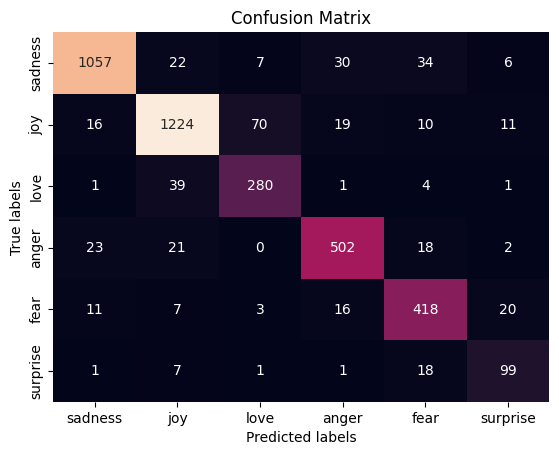

In [53]:
best_estimator = randomized_search.best_estimator_
y_pred = best_estimator.predict(X_test_tfidf)
evaluate_performance(y_true, y_pred)

After hyperparameter tuning, we can see a very similar pattern that we previously saw when tuning Logistic Regression. While there was an overall improvement in performance, it came at the expense of the minority classes.